#구글 드라이브 마운트하여 구글 드라이브 사용

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


#GradCAM

In [4]:
!pip install git+https://github.com/jacobgil/pytorch-grad-cam.git

  Cloning https://github.com/jacobgil/pytorch-grad-cam.git to /tmp/pip-req-build-kliidk7i
  Running command git clone --filter=blob:none --quiet https://github.com/jacobgil/pytorch-grad-cam.git /tmp/pip-req-build-kliidk7i
  Resolved https://github.com/jacobgil/pytorch-grad-cam.git to commit a797af22fd07fce03a1075401659a67401d22c6f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.8-py3-none-any.whl size=37545 sha256=6c163f9cc55a865bd8388063410417422cb199aacd6ab3fcd0ce74a370d9825d
  Stored in directory: /tmp/pip-ephem-wheel-cache-14dlh575/wheels/23/11/66/71a38b0c29ba4ec5f62105a2145278613855bc9c94eecf630d
Successfully built grad-cam


In [12]:
import copy
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet18
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torchvision
import torch
import torch.nn as nn
from torchvision import models
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn # 인공 신경망 모델들 모아놓은 모듈
import torch.nn.functional as F #그중 자주 쓰이는것들을 F로
from torchvision import transforms, datasets
import cv2
import pandas as pd
import os
from glob import glob
import torchvision.models as models
import sys
import librosa, librosa.display
#from pytorchtools import EarlyStopping
from torch.utils.data import random_split, DataLoader
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split

if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
#DEVICE = torch.device('cpu')
print('Using Pytorch version : ',torch.__version__,' Device : ',DEVICE)

#3. 하이퍼 파라미터
BATCH_SIZE =  64 #한 배치당 64개 이미지데이터
EPOCHS = 100# 전체 데이터 셋을 50번 반복

Using Pytorch version :  2.1.0+cu121  Device :  cuda


In [3]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [13]:
# 저장한 모델 불러오기
#loaded_model = models.vgg16()
loaded_model = models.vgg16()
loaded_model.classifier[-1] = nn.Linear(4096, 2)  # 마지막 층을 이진 분류에 맞게 변경

#loaded_model.classifier[-1] = nn.Linear(4096, 2)  # 마지막 층을 이진 분류에 맞게 변경
loaded_model.load_state_dict(torch.load('/content/drive/MyDrive/느티나무 질병 데이터셋/parameter/성능 비교_VGG16 Pretrained O + Data_Aug_O + 불균형 해소'))

loaded_model.to(DEVICE)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
"""
import torch
import torch.nn as nn
import torchvision.models as models

# 저장한 모델 불러오기
#loaded_model = models.vgg16()
loaded_model = models.densenet201(pretrained=True)
num_ftrs = loaded_model.classifier.in_features
loaded_model.classifier = nn.Linear(num_ftrs, 2)

#loaded_model.classifier[-1] = nn.Linear(4096, 2)  # 마지막 층을 이진 분류에 맞게 변경
loaded_model.load_state_dict(torch.load('/content/drive/MyDrive/느티나무 질병 데이터셋/parameter/DenseNet201 Pretrained O + DataAug(Num O, Jitter, Affine X) + Adam + Lambda_Sch20 + epochs500'))
#'/content/drive/MyDrive/느티나무 질병 데이터셋/parameter/DenseNet201 Pretrained O + DataAug(Num X, Jitter, Affine X) + Adam + Lambda_Sch' ９９。２７‰
loaded_model.to(DEVICE)
"""

In [15]:
test_data_dir = '/content/drive/MyDrive/느티나무 질병 데이터셋/test'
transform_test = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to the same size used in training
    transforms.ToTensor(),  # Convert to a tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize using the same mean and standard deviation as training
])
test_dataset = ImageFolder(root=test_data_dir, transform=transform_test)

test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)

In [16]:
def evaluate2(model,test_loader):
    model.eval()
    misclassified_images = []
    test_loss = 0
    correct = 0
    test_losses=[]
    test_acc=[]
    indexes = [0, 1]

    # 예측과 실제 라벨 리스트 초기화
    all_predictions = []
    all_labels = []

    test_loss = 0
    test_a = 0
    #no_grad : 그래디언트 값 계산 막기.
    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()

            prediction = output.max(1,keepdim=True)[1] # 가장 확률이 높은 class 1개를 가져온다.그리고 인덱스만
            correct += prediction.eq(label.view_as(prediction)).sum().item()# 아웃풋이 배치 사이즈 32개라서.

            all_predictions.extend(prediction.cpu().numpy())
            all_labels.extend(label.cpu().numpy())
            # Check for misclassified images
            for i in range(label.size(0)):
                if prediction[i] != label[i]:
                    misclassified_images.append((image[i], prediction[i], label[i]))

        test_loss /= len(test_loader.dataset)
        test_a = 100. * correct / len(test_loader.dataset)

        return test_loss, test_a, misclassified_images, all_predictions, all_labels

In [20]:
criterion = nn.CrossEntropyLoss()

In [21]:
test_loss, test_a, misclassified_images, all_predictions, all_labels = evaluate2(loaded_model, test_loader)

criterion = nn.CrossEntropyLoss()
print("test_loss: ", test_loss, "test_acc", test_a)

test_loss:  5.534563493764285e-05 test_acc 100.0


In [ ]:
"""
#Densenet201
model = loaded_model
# Pick up layers for visualization
target_layers = [model.features[11]]
"""

'\n#Densenet201\nmodel = loaded_model\n# Pick up layers for visualization\ntarget_layers = [model.features[11]]\n'

In [24]:
model = loaded_model
# Pick up layers for visualization

target_layers = [model.features[30]]
# VGG16 = features[30]
# vgg19 + CBAM target_layers = [model.conv_block5[3]]

<ipython-input-25-1f2e6d104115>:20: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_img = original_img.resize((224, 224), Image.ANTIALIAS)


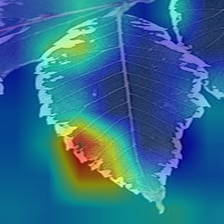

In [25]:
from PIL import Image
import numpy as np
import torchvision.transforms as transforms

"""
"/content/drive/MyDrive/느티나무 질병 데이터셋/test/healthy/flickr_172_3.jpg"

"/content/drive/MyDrive/느티나무 질병 데이터셋/test/disease/elm_anthracnose_fig1_3.jpg"

"/content/drive/MyDrive/느티나무 질병 데이터셋/test/disease/flickr_34_0.jpg"

"/content/drive/MyDrive/느티나무 질병 데이터셋/test/disease/flickr_180_1.jpg"
"""

# Load the image
path = "/content/drive/MyDrive/느티나무 질병 데이터셋/test/disease/flickr_180_1.jpg"
original_img = Image.open(path).convert('RGB')

# Resize the image to 32x32
resized_img = original_img.resize((224, 224), Image.ANTIALIAS)

# Max min normalization
rgb_img = (np.array(resized_img) - np.min(resized_img)) / (np.max(resized_img) - np.min(resized_img))

input_tensor = torchvision.transforms.functional.to_tensor(rgb_img).unsqueeze(0).float().to(DEVICE)
# Note: input_tensor can be a batch tensor with several images!

# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=False)

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=input_tensor)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

Image.fromarray(visualization, 'RGB')